# Home assignment #3

**Author: Márton Nagy**

**Course: Web Scraping with Python**

In my third home assignment, I have decided to scrape all the English-language reviews on Ryanair from TrustPilot in order to find out whether there is a relationship between Ryanair's stock price (RYAAY) and the average ratings and the average sentiment of the ratings it receives. I download the historical stock price of Ryanair from the Yahoo Finance API. I've also included some other control variables scraped from Ryanair's website, namely monthly number of passengers and monthly load factor. 

First, I import the necessary packages.

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from scrapethat import *
from plotnine import *
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
import json
import random
from stem import Signal
from stem.control import Controller
import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from mizani.formatters import percent_format
import copy
import os

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nagym\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Part 1: Gathering the data

I start the data gathering process with the most complex task of all: scraping all reviews from TrustPilot. The complexity of this task lies in the fact, that the API used by browsers to load reviews while browsing was not intended to serve automated scraping bots. As a result, it quickly detects if it gets too many requests from one IP adress, and bans it temporarily. I will later describe how I was able to circumvent this issue.

But first, I simply define a function that makes an API call to the API that I have extracted from my browser's Network tab. The only complexity here is that I rotate my user agent headers randomly, an added measure to mitigate the eventual ban.

In [14]:
def get_reviews_page(session, page):
    #I rotate randomly my user agent header to avoid being banned.
    USER_AGENTS = [
        # Windows User Agents
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:110.0) Gecko/20100101 Firefox/110.0',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Edge/114.0.0.0 Safari/537.36',
    
        # MacOS User Agents
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.2 Safari/605.1.15',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 12_3_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_4) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.3 Safari/605.1.15',
    
        # Linux User Agents
        'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
        'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:90.0) Gecko/20100101 Firefox/90.0',
        'Mozilla/5.0 (X11; Fedora; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36',
    
        # Mobile User Agents
        'Mozilla/5.0 (iPhone; CPU iPhone OS 16_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.0 Mobile/15E148 Safari/604.1',
        'Mozilla/5.0 (iPad; CPU OS 15_4 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Mobile/15E148 Safari/604.1',
        'Mozilla/5.0 (Linux; Android 13; Pixel 6 Pro) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Mobile Safari/537.36',
        'Mozilla/5.0 (Linux; Android 12; SM-G998B) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Mobile Safari/537.36',
    
        # Older Browser Versions
        'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
        'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:78.0) Gecko/20100101 Firefox/78.0',
    ]
    headers = {
        'accept': '*/*',
        'accept-language': 'en-US,en;q=0.9',
        'dnt': '1',
        'priority': 'u=1, i',
        'referer': f'https://www.trustpilot.com/review/www.ryanair.com?page={page}',
        'sec-ch-ua': '"Google Chrome";v="131", "Chromium";v="131", "Not_A Brand";v="24"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-origin',
        'user-agent': random.choice(USER_AGENTS),
        'x-nextjs-data': '1',
    }
    #scraping the first page requires a slightly different syntax.
    if page == 1:
        params = {
            'languages': 'en',
            'sort': 'recency',
            'businessUnit': 'www.ryanair.com',
        }
    else:
        params = {
            'languages': 'en',
            'page': str(page),
            'sort': 'recency',
            'businessUnit': 'www.ryanair.com',
        }
    try:   
        response = session.get(
            'https://www.trustpilot.com/_next/data/businessunitprofile-consumersite-2.2616.0/review/www.ryanair.com.json',
            params=params,
            headers=headers,
        )
    except Exception as e:
        print(f'Exception: {e}')
        return None
    #the function prints the HTTP code if something goes wrong
    if response.status_code != 200:
        print(f'HTTP: {response.status_code}')
        return None
    return json.loads(response.text)['pageProps']['reviews']

The real deal comes now, however! In order to scrape all pages, I decided to bypass the API's rate limit by making the calls through a constantly renewed TOR circuit. To set this up, I included the following things in my TOR browser's `torrc` file (replace with variables matching your system):

```
ControlPort <CONTROL_PORT>
CookieAuthentication 0
HashedControlPassword <TOR_HASHED_PW>
ExitNodes {us}
SOCKSPort <PROXY_HTTP>
```

With these set up, we can now connect to the TOR circuit programmaticaly with the below functions. An important caveat though, is that you must have your TOR browser running before running the codes.

In [3]:
def renew_tor_ip():
    with Controller.from_port(port=int(os.environ.get('CONTROL_PORT'))) as controller:
        controller.authenticate(os.environ.get('TOR_PW'))
        controller.signal(Signal.NEWNYM)

def create_tor_session():
    session = requests.Session()
    session.proxies.update({
        'http': os.environ.get('PROXY_HTTP'),
        'https': os.environ.get('PROXY_HTTPS'),
    })
    return session

Now we can easily (though quite slowly) scrape all pages from TrustPilot. A key thing this code does, is that it renews it's TOR IP after every 50 page scraped - and this way, it bypasses the rate limit.

The code runs until we either run into an error or get an HTTP response other than 200 for a call. As we can see, the code stopped after it get an HTTP 404. We can be happy about this, as this means that it scraped all the pages, until there was none left. All in all, it scraped 14,748 reviews.

In [15]:
run = True
i = 1
reviews_list = []
renew_tor_ip()
session = create_tor_session()
while run:
    if i % 10 == 0:
        print(f'At page: {i}')
    if i % 50 == 0:
        renew_tor_ip()
        session = create_tor_session()
    t = get_reviews_page(session, i)
    if t is None:
        run = False
        print(f'Stopped at page {i}')
    else:
        reviews_list.extend(t)
        i += 1
len(reviews_list)

At page: 10
At page: 20
At page: 30
At page: 40
At page: 50
At page: 60
At page: 70
At page: 80
At page: 90
At page: 100
At page: 110
At page: 120
At page: 130
At page: 140
At page: 150
At page: 160
At page: 170
At page: 180
At page: 190
At page: 200
At page: 210
At page: 220
At page: 230
At page: 240
At page: 250
At page: 260
At page: 270
At page: 280
At page: 290
At page: 300
At page: 310
At page: 320
At page: 330
At page: 340
At page: 350
At page: 360
At page: 370
At page: 380
At page: 390
At page: 400
At page: 410
At page: 420
At page: 430
At page: 440
At page: 450
At page: 460
At page: 470
At page: 480
At page: 490
At page: 500
At page: 510
At page: 520
At page: 530
At page: 540
At page: 550
At page: 560
At page: 570
At page: 580
At page: 590
At page: 600
At page: 610
At page: 620
At page: 630
At page: 640
At page: 650
At page: 660
At page: 670
At page: 680
At page: 690
At page: 700
At page: 710
At page: 720
At page: 730
HTTP: 404
Stopped at page 739


14748

As this scraping process was quite slow, I save the results into a JSON file so that I do not have to run the code again, and I work further with what has been saved into the file.

In [16]:
os.makedirs('data', exist_ok=True)

In [17]:
with open(os.path.join('data', 'reviews_list.json'), 'w') as f:
    json.dump(reviews_list, f)

In [18]:
with open(os.path.join('data', 'reviews_list.json'), 'r') as f:
    review_data = json.load(f)

Now, we can parse the scraped reviews with an appropriate function and a map. Note that I scale the ratings to a 0-1 scale to be later compareble with sentiments.

In [19]:
def parse_review(review):
    return {
        'id' : review['id'],
        'title' : review['title'],
        'text' : review['text'].replace('\n', ' '),
        'rating' : review['rating'] / 5,
        'likes' : review['likes'],
        'reviewer_country' : review['consumer']['countryCode'],
        'language' : review['language'],
        'experience_date' : review['dates']['experiencedDate'],
        'published_date' : review['dates']['publishedDate']
    }

We then turn this into a DataFrame, adjust the type of date columns, and separate years, months and weeks from the dates.

In [20]:
reviews = list(map(parse_review, review_data))
reviews_df = pd.DataFrame(reviews)
reviews_df['experience_date'] = pd.to_datetime(reviews_df['experience_date'], errors='coerce')
reviews_df['published_date'] = pd.to_datetime(reviews_df['published_date'], errors='coerce')
reviews_df['published_year'] = reviews_df['published_date'].dt.year
reviews_df['published_month'] = reviews_df['published_date'].dt.month
reviews_df['published_week'] = reviews_df['published_date'].apply(lambda x: x.isocalendar().week)
reviews_df.sort_values('published_date', inplace = True)

As we want to work primarily with montly data, let's look at how many month have reviews in each year.

In [21]:
pd.DataFrame(reviews_df[['published_year', 'published_month']].value_counts()).sort_values(['published_year', 'published_month']).reset_index().published_year.value_counts()

published_year
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021    12
2022    12
2023    12
2024    12
2010     7
2009     2
Name: count, dtype: int64

As we can see, we have complete covarage for years after 2010 - so let's filter to that.

In [22]:
reviews_df = reviews_df[reviews_df['published_year'] > 2010]

However, we might not want to work with data where the average number of montly reviews is small (e.g. below 50) because then the monthly averages may be rather noisy. So we end up with years 2018-2024.

In [23]:
reviews_df.published_year.value_counts()/12

published_year
2024    208.666667
2023    207.333333
2022    185.000000
2020    183.000000
2021    129.333333
2019     96.083333
2018     71.833333
2017     48.416667
2012     35.000000
2011     23.416667
2016     18.000000
2015     11.750000
2014      4.583333
2013      2.500000
Name: count, dtype: float64

In [24]:
reviews_df = reviews_df[reviews_df['published_year'] > 2017]

Now let's turn away from the reviews, and get the other data we need! First, I use the Yahoo Finance API to get historical price data on Ryanair's stock (that is RYAAY).

In [25]:
def get_olhc(ticker, range='2y', interval='1d' ):
    try:

        scraper = cloudscraper.create_scraper()
        response = scraper.get(f"https://query1.finance.yahoo.com/v8/finance/chart/{ticker}?interval={interval}&range={range}")
        t= response.json()
        df = pd.DataFrame(t['chart']['result'][0]['indicators']['quote'][0])
        df['date'] = pd.to_datetime(t['chart']['result'][0]['timestamp'], unit='s')
        df = df[['date', 'open', 'low', 'high', 'close', 'volume']]
        df['name']= ticker
        return(df)

    except:
        print('error')
        pass

In [26]:
ryaay = get_olhc('RYAAY', range = f'{datetime.datetime.now().year - reviews_df.published_year.min() + 1}y')
ryaay = ryaay.sort_values(by='date')

Again, I extract years, months and weeks from the dates, and filter to years above 2017.

In [27]:
ryaay['week'] = ryaay['date'].apply(lambda x: x.isocalendar().week)
ryaay['month'] = ryaay['date'].apply(lambda x: x.month)
ryaay['year'] = ryaay['date'].apply(lambda x: x.isocalendar().year)

In [28]:
ryaay = ryaay[ryaay['year'] > 2017]

My third data source is Ryanair's website, where they publish monthly data for their passenger (guest) numbers and load factor. I simply scrape the HTML code of this site. Scraping this is rather easy, as we can simply find all HTML tables, and read them directly into Pandas. Then we can clean up the DataFrame using Pandas.

In [29]:
stats = read_cloud('https://investor.ryanair.com/traffic/')
tables = stats.find_all('table')

In [30]:
def parse_ryanair_tables(tables):
    #month mapping for date conversion
    month_map = {
        "Apr.": 4, "May": 5, "Jun.": 6, "Jul.": 7, "Aug.": 8,
        "Sep.": 9, "Oct.": 10, "Nov.": 11, "Dec.": 12,
        "Jan.": 1, "Feb.": 2, "Mar.": 3
    }
    
    dfs = []
    for table in tables:
        #reading to pandas from HTML
        df = pd.read_html(str(table))[0]
        #the column names of the tables were incostint (e.g. extra whitespaces), so I assign them manually
        df.columns = ['Unnamed: 0', 'Guests (m)', 'Guests (m).1', 'Guests (m).2', 'Unnamed: 4', 'L.  Fact', 'L.  Fact.1']
        #all tables present data for two financial years, so I extract only the later, and turn it into an integer
        header_row = df.iloc[0]
        later_fy_raw = header_row[2] 
        later_fy = int(''.join(filter(str.isdigit, str(later_fy_raw)))) + 2000
        
        guests_col = "Guests (m).1"
        load_factor_col = "L.  Fact.1"

        #now I filter out rows that do not contain actual data
        df = df[df["Unnamed: 0"].isin(month_map.keys())]
        
        #I get the month number with the mappin dictionary
        df["month"] = df["Unnamed: 0"].map(month_map)
        #Getting the actual year of the data is a bit tricky, as I have to adjust
        #for Ryanair's financial year starting in April
        df["year"] = df["month"].apply(
            lambda m: later_fy - 1 if m >= 4 else later_fy
        )
        
        #now we can create an actual date column
        df["date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))
        
        #and extract the passenger and load factor data points
        df["guests"] = pd.to_numeric(df['Guests (m).1'], errors="coerce")
        df["load_factor"] = df['L.  Fact.1'].apply(lambda x: np.nan if x == '–' else float(str(x).strip('%')) / 100)
        
        #lastly, I filter to the relevant columns only
        dfs.append(df[["year", "month", "date", "guests", "load_factor"]])
    
    #and return a combined DataFrame
    return pd.concat(dfs, ignore_index=True)


Here, I again filter to rows after 2017.

In [31]:
stats_df = parse_ryanair_tables(tables)
stats_df.sort_values('date', inplace=True)
stats_df = stats_df[stats_df['year'] > 2017]

# Part 2: EDA

Before we can join the three datasources, we still need to calculate sentiment scores for all of the reviews. I do this with the `nltk.sentiment.SentimentIntensityAnalyzer` function, using the VADER dictionary. I scale the sentiments from -1 to +1 to a 0-1 scale.

In [32]:
sia = SentimentIntensityAnalyzer()
reviews_df['sentiment_score'] = reviews_df['text'].apply(lambda review: (sia.polarity_scores(review)['compound'] + 1)/2)

Now we can join the three data tables. For this, I calculate monthly average ratings and monthly average sentiment scores for the reviews, and montly last closing prices for the stock data.

In [33]:
reviews_monthly = (
    reviews_df
    .groupby(['published_year', 'published_month'], as_index=False)
    .agg(avg_rating = ('rating', 'mean'),
         avg_sentiment =  ('sentiment_score', 'mean')
        )
)

ryaay_monthly = ryaay.groupby(['year', 'month']).last().reset_index()[['year', 'month', 'date', 'close']].rename(columns={'close': 'ryaay'})

In [34]:
ts_monthly = (ryaay_monthly
              .merge(reviews_monthly, how = 'outer', left_on=['year', 'month'], right_on=['published_year', 'published_month'])
              .merge(stats_df, how = 'outer', on = ['year', 'month'])
             )
ts_monthly.drop(columns=['published_year', 'published_month', 'date_y'], inplace=True)
ts_monthly.rename(columns={'date_x' : 'date'}, inplace = True)

I create some dummies for certain external shock factors. Also, I impute the load factor with zeros (as during the lockdown period, there were few missing values) and drop observations where we have any missing data. I also create a quarter variable.

In [35]:
ts_monthly['lockdown'] = ts_monthly['date'].apply(lambda x: 1 if pd.Timestamp("2020-04-01T00:00:01") <= x <= pd.Timestamp("2021-04-30T23:59:59") else 0)
ts_monthly['war'] = ts_monthly['date'].apply(lambda x: 1 if pd.Timestamp("2022-02-01T00:00:01") <= x <= pd.Timestamp("2023-06-30T23:59:59") else 0)
ts_monthly.load_factor.fillna(0, inplace = True)
ts_monthly.dropna(inplace=True)
ts_monthly['quarter'] = ts_monthly.date.dt.quarter
ts_monthly.sort_values('date', inplace=True)

Now we can plot the raw time series!

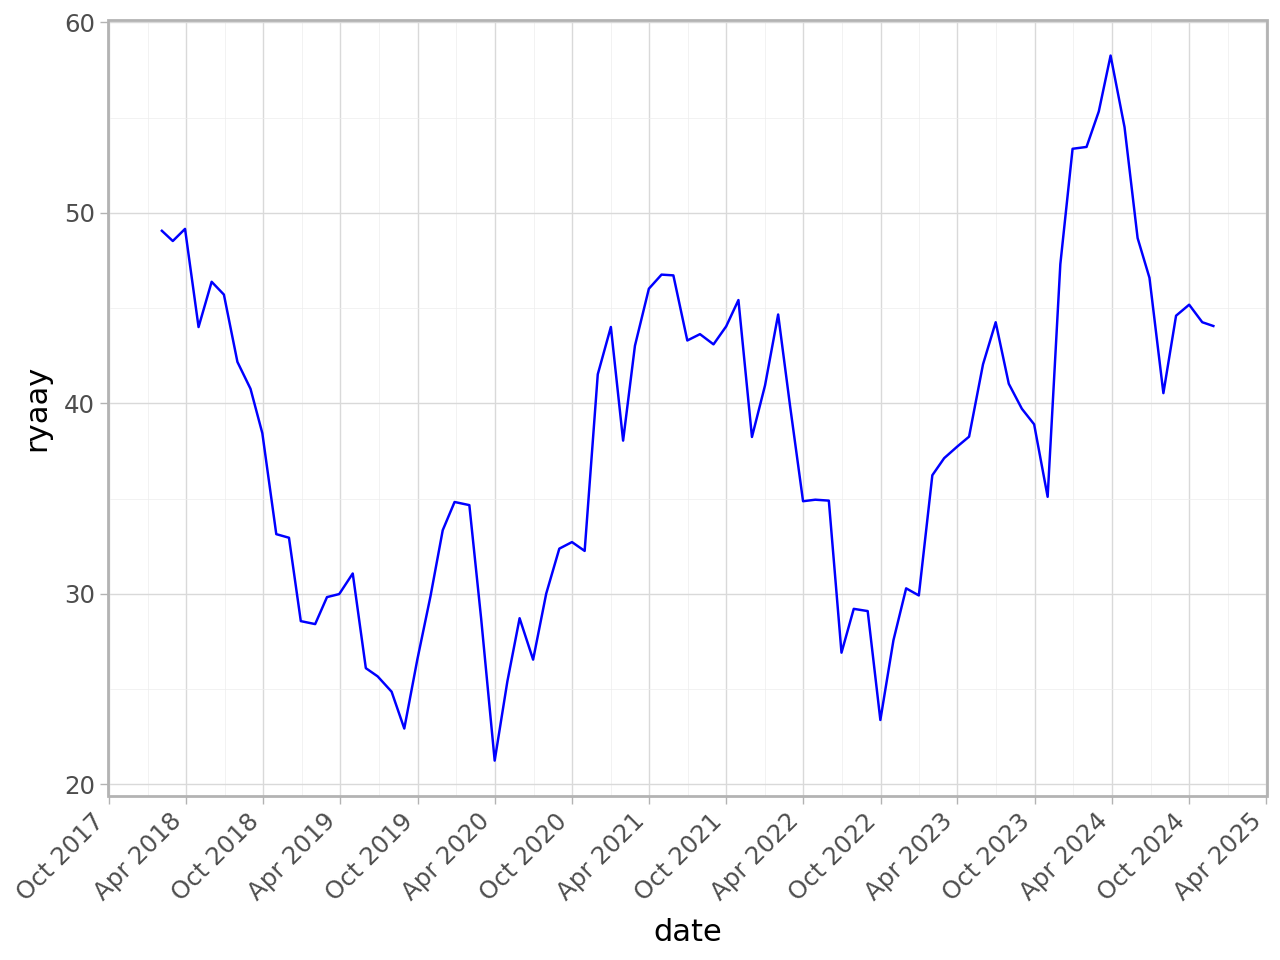

In [36]:
(
    ggplot(ts_monthly)
    + theme_light()
    + aes(x='date')
    + geom_line(aes(y='ryaay'), color='blue')
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

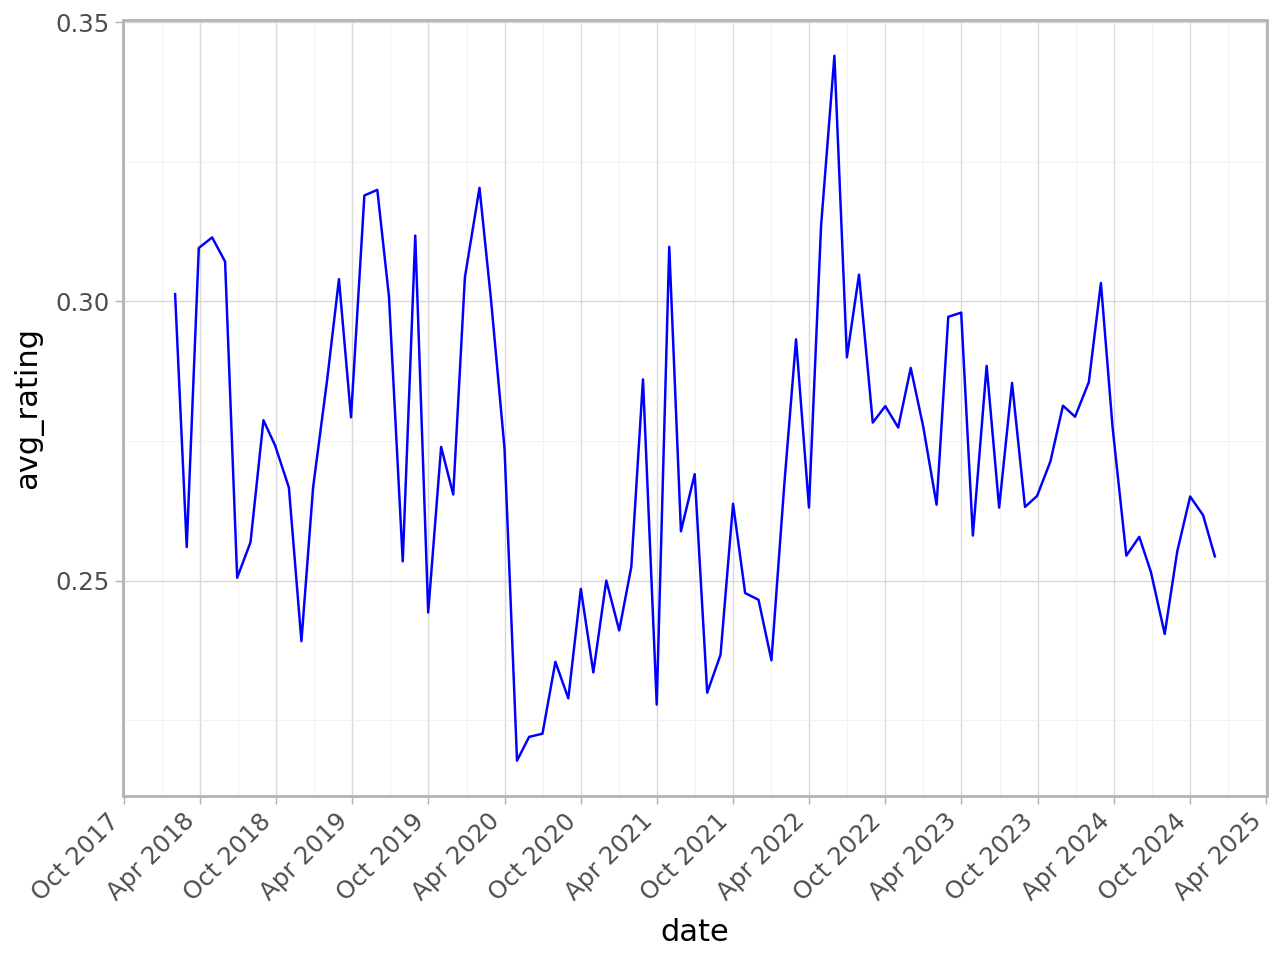

In [37]:
(
    ggplot(ts_monthly)
    + theme_light()
    + aes(x='date')
    + geom_line(aes(y='avg_rating'), color='blue')
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

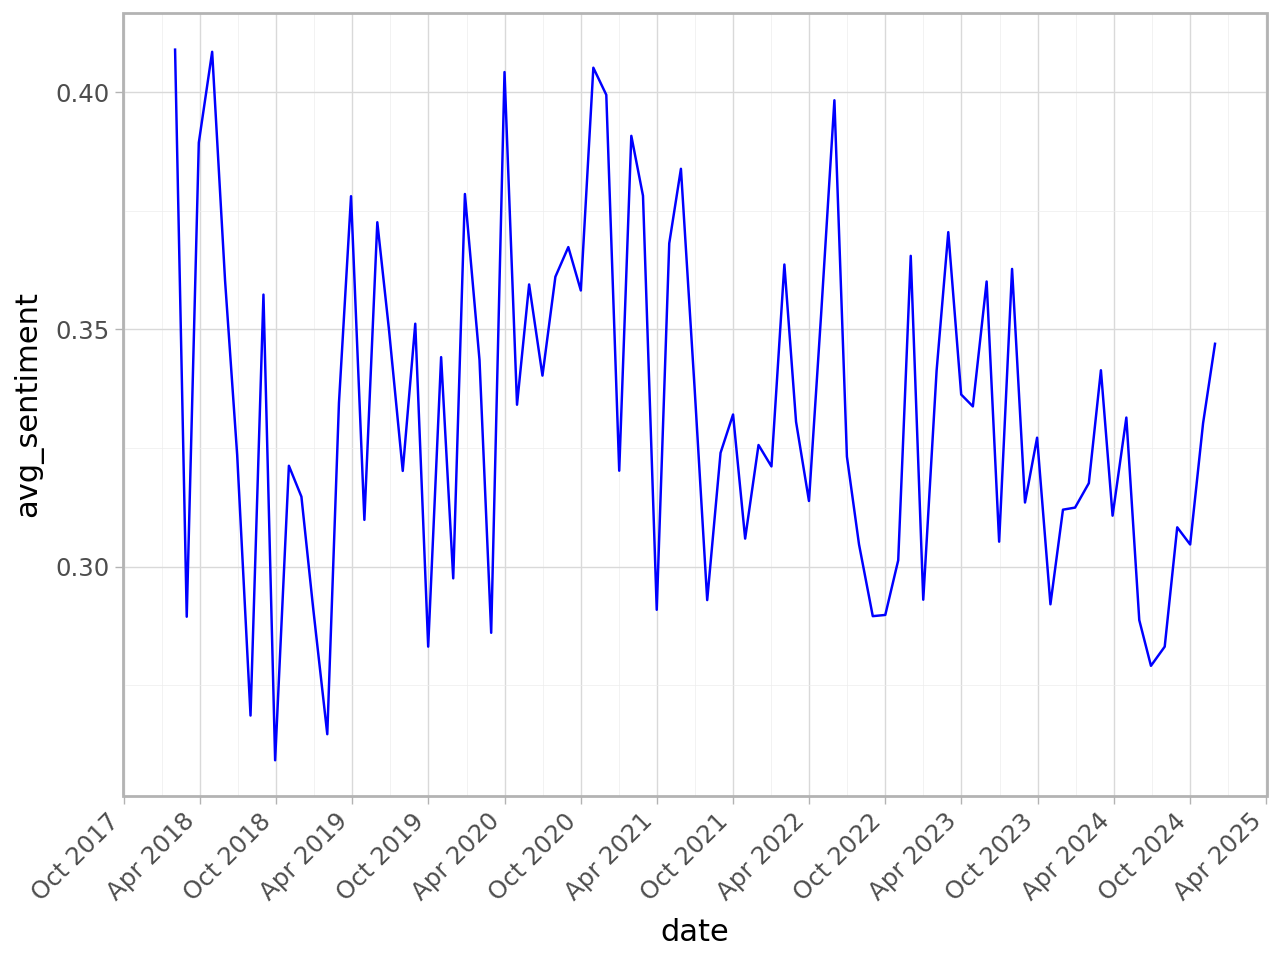

In [38]:
(
    ggplot(ts_monthly)
    + theme_light()
    + aes(x='date')
    + geom_line(aes(y='avg_sentiment'), color='blue')
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

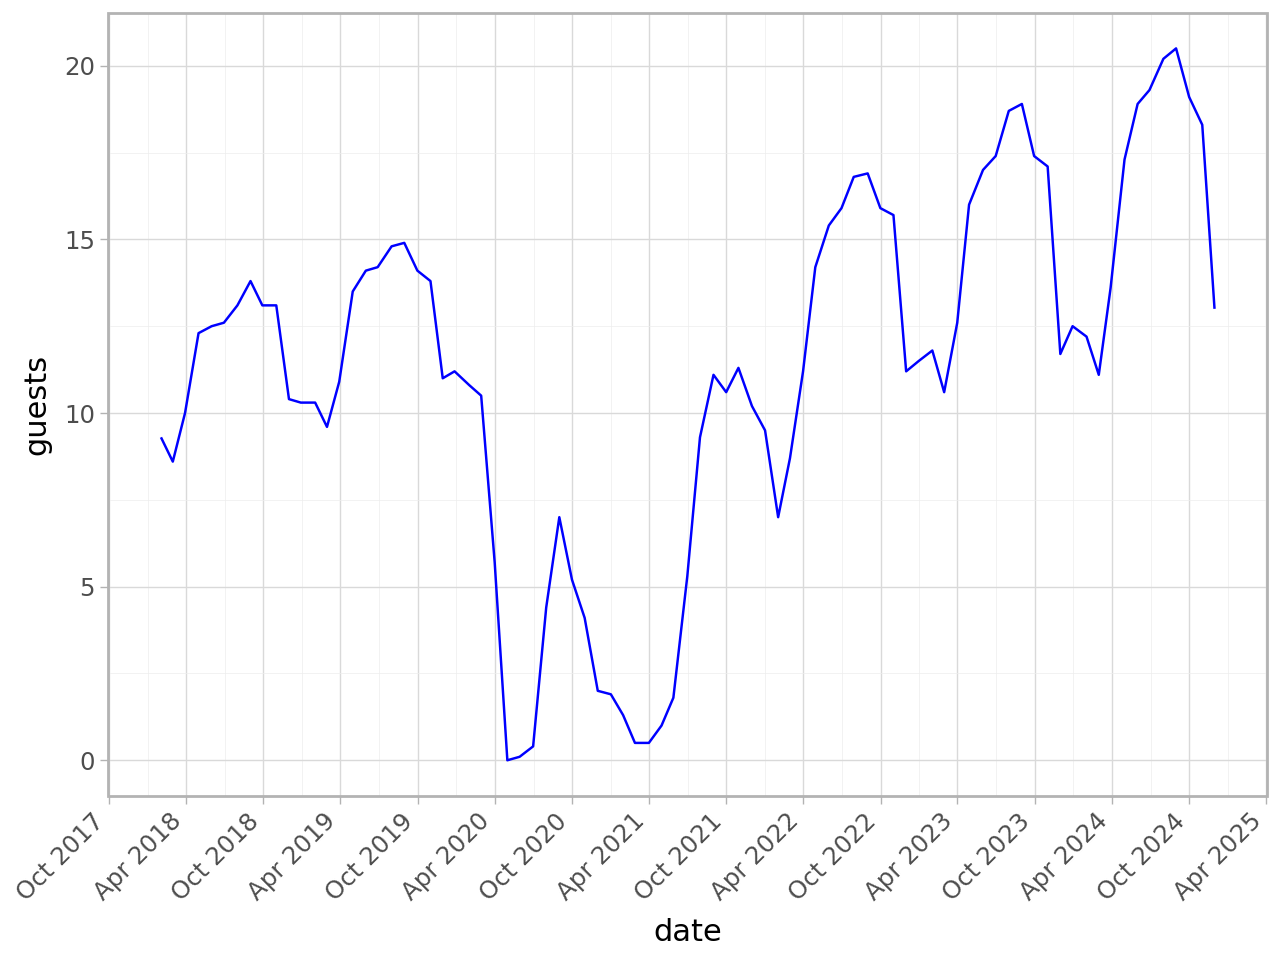

In [39]:
(
    ggplot(ts_monthly)
    + theme_light()
    + aes(x='date')
    + geom_line(aes(y='guests'), color='blue')
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

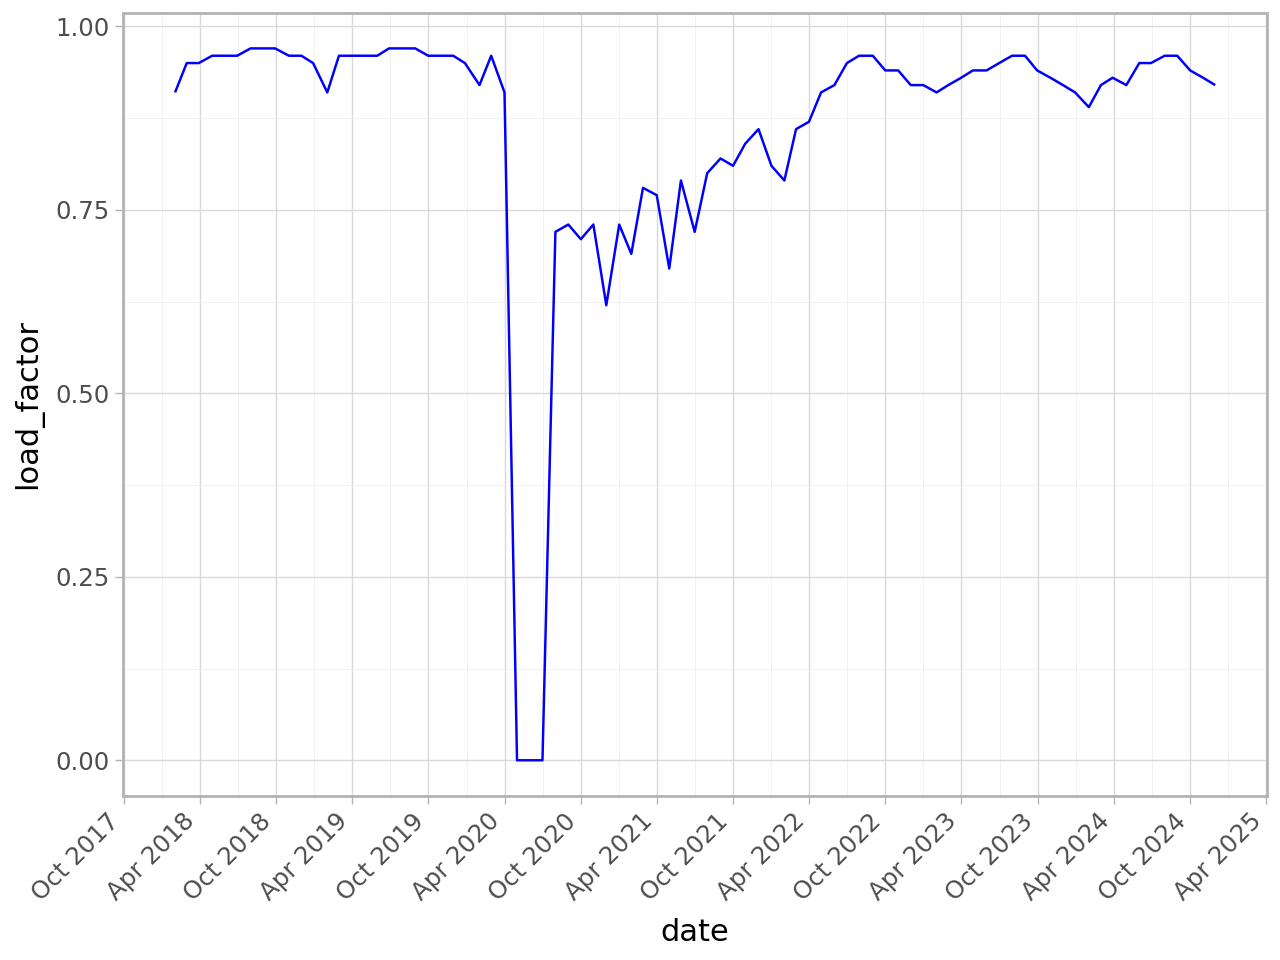

In [40]:
(
    ggplot(ts_monthly)
    + theme_light()
    + aes(x='date')
    + geom_line(aes(y='load_factor'), color='blue')
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

As we can see, none of them seems stationary, so we should take differences. I take log differences for the stock price, and simple differences for the other variables.

In [41]:
for x in ["ryaay"]:
    ts_monthly["dln_" + x] = np.log(ts_monthly[x]) - np.log(ts_monthly[x].shift())

for x in ["avg_rating", "avg_sentiment", "guests", 'load_factor']:
    ts_monthly["d_" + x] = ts_monthly[x] - ts_monthly[x].shift()

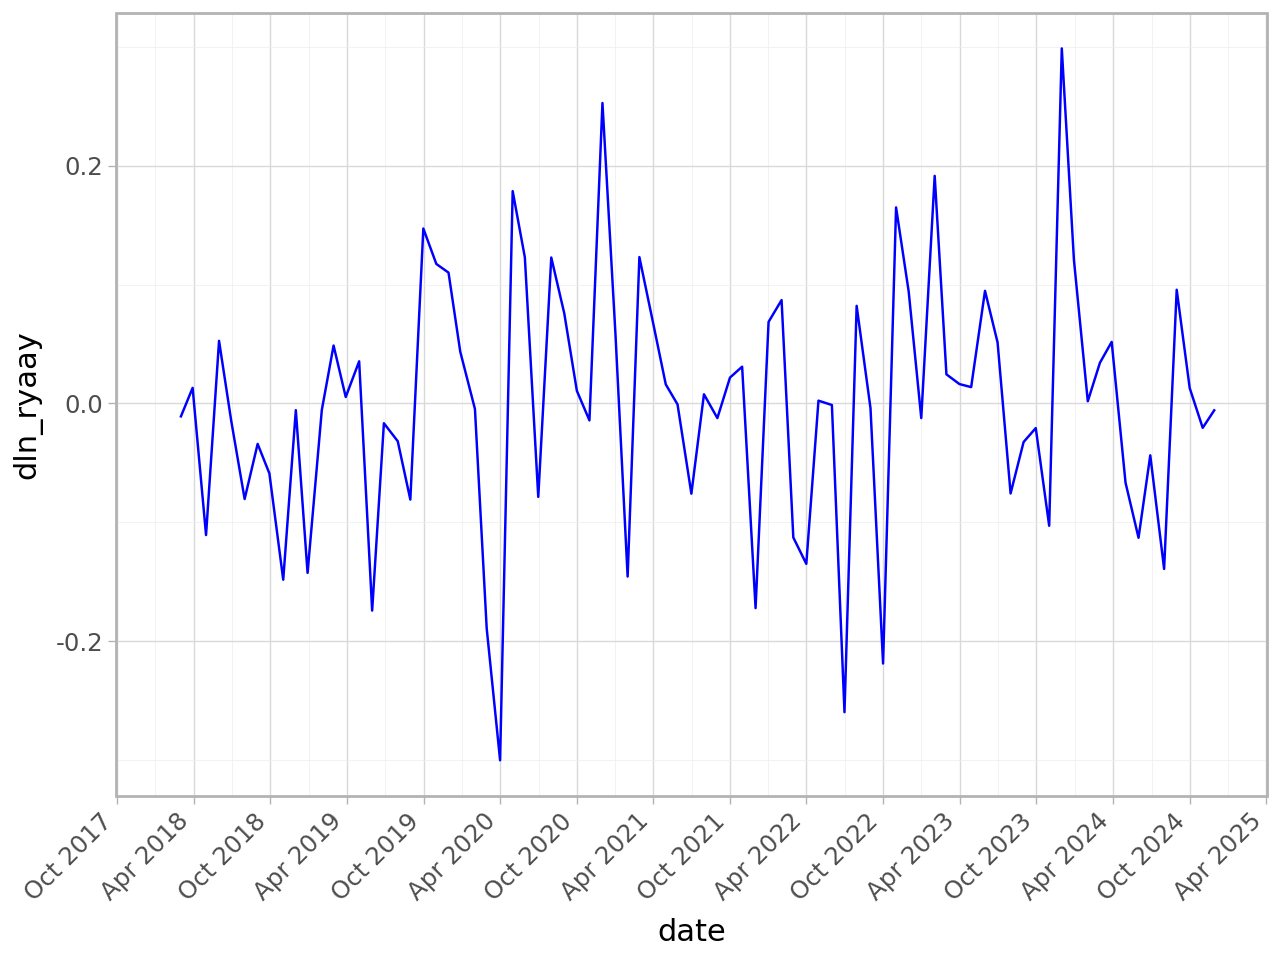

In [42]:
(
    ggplot(ts_monthly)
    + theme_light()
    + aes(x='date')
    + geom_line(aes(y='dln_ryaay'), color='blue')
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

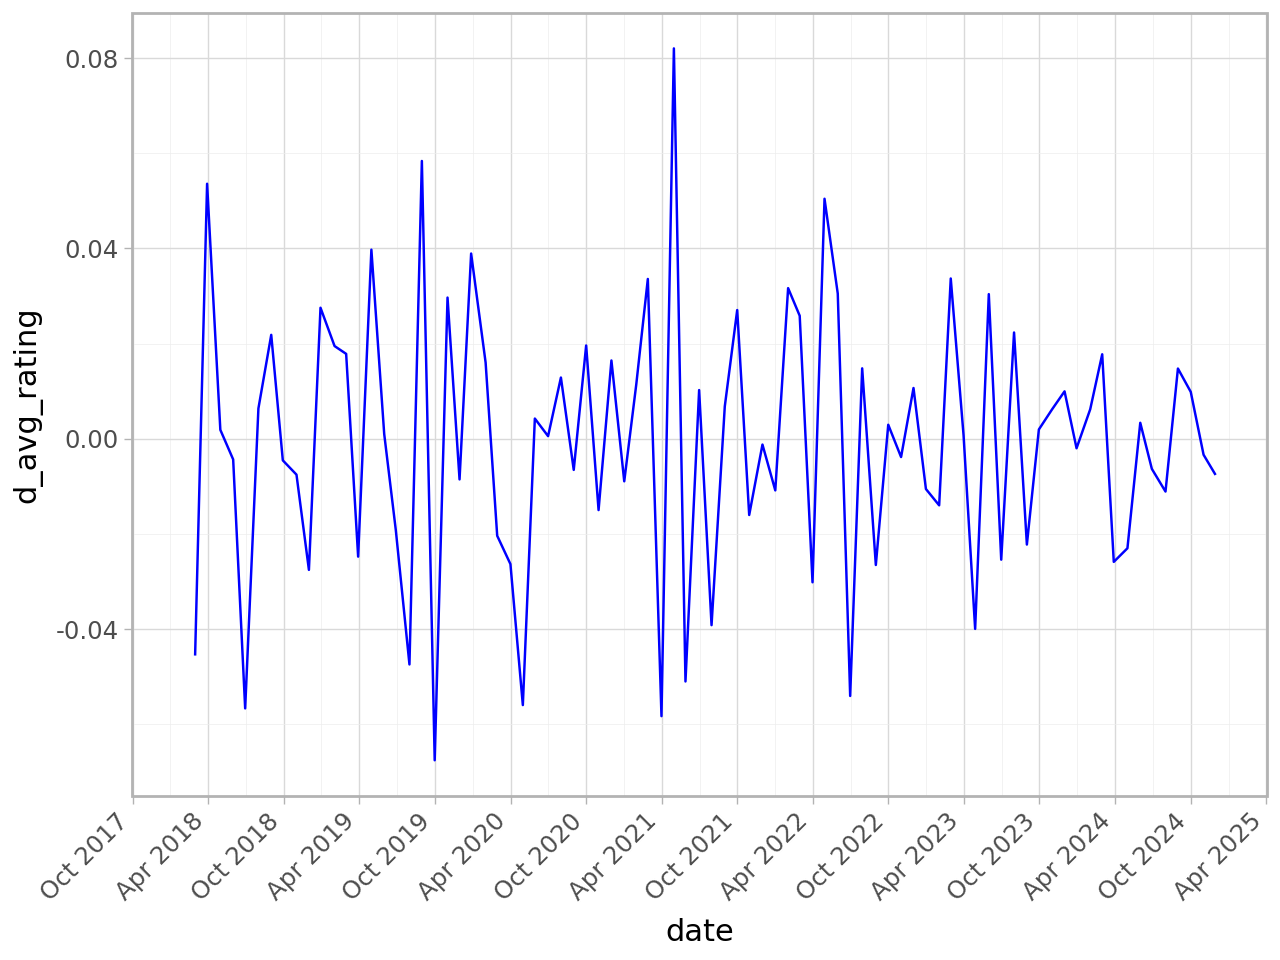

In [43]:
(
    ggplot(ts_monthly)
    + theme_light()
    + aes(x='date')
    + geom_line(aes(y='d_avg_rating'), color='blue')
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

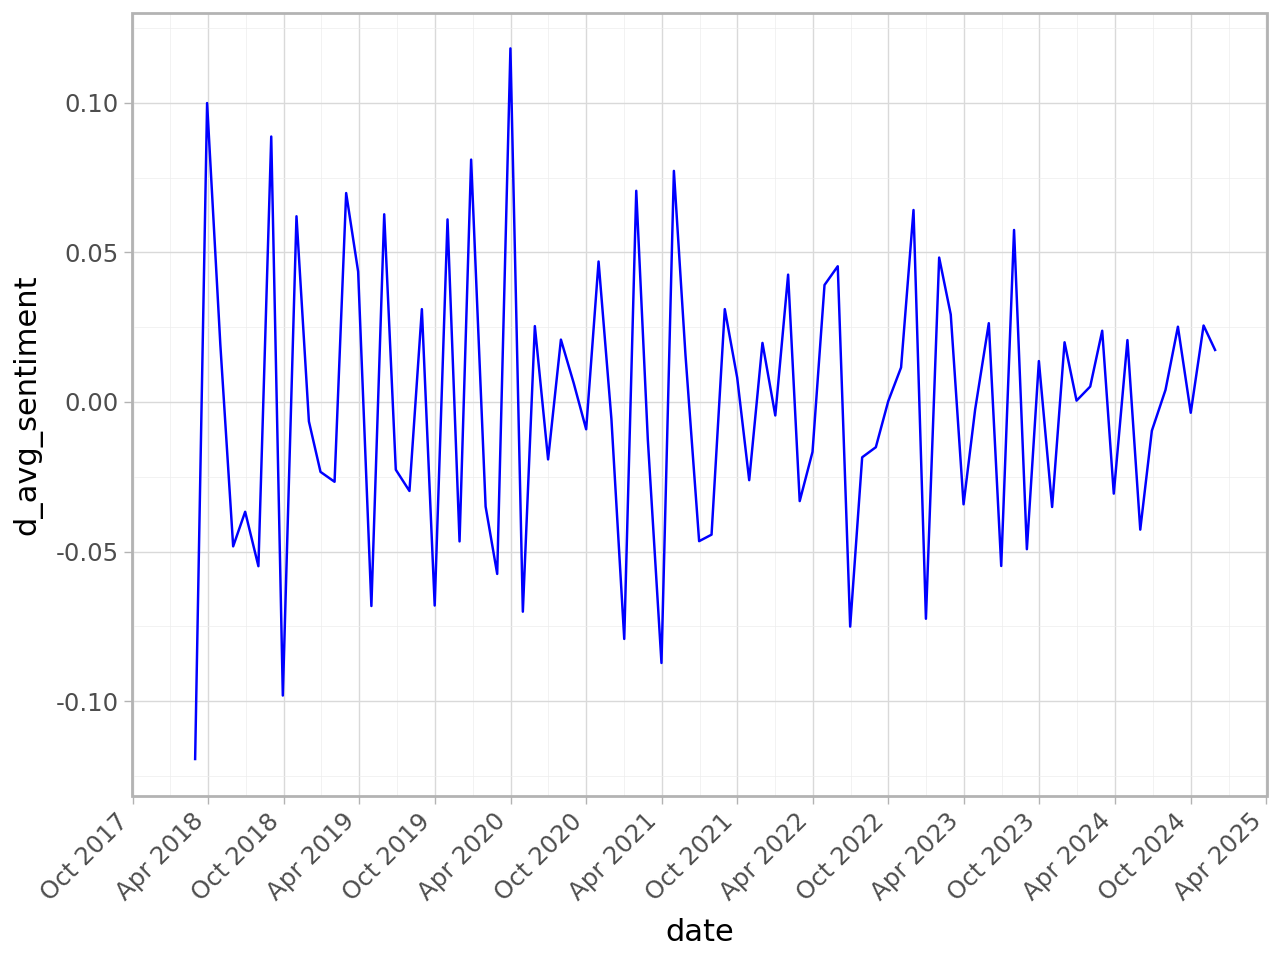

In [44]:
(
    ggplot(ts_monthly)
    + theme_light()
    + aes(x='date')
    + geom_line(aes(y='d_avg_sentiment'), color='blue')
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

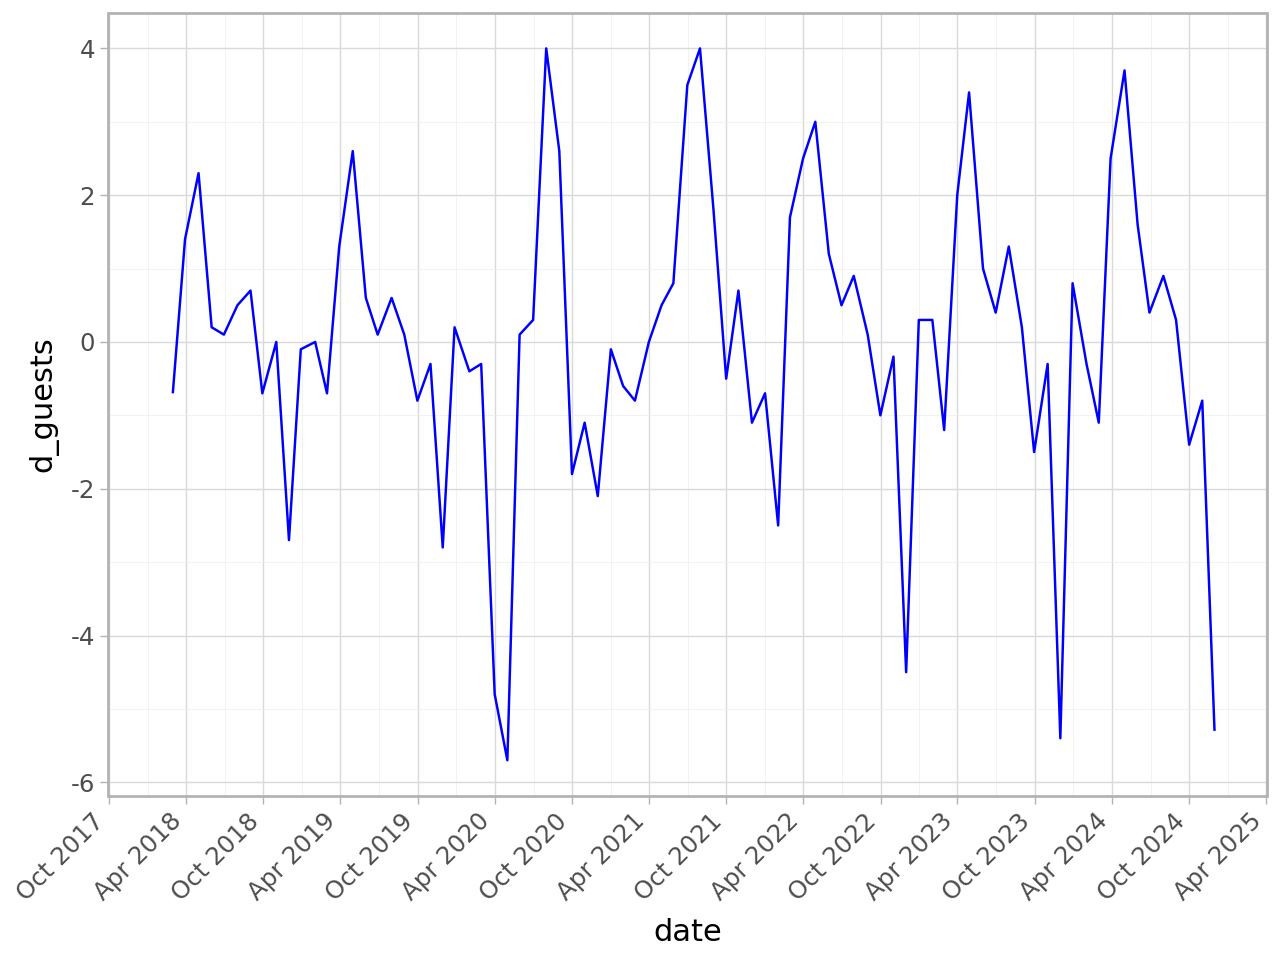

In [45]:
(
    ggplot(ts_monthly)
    + theme_light()
    + aes(x='date')
    + geom_line(aes(y='d_guests'), color='blue')
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

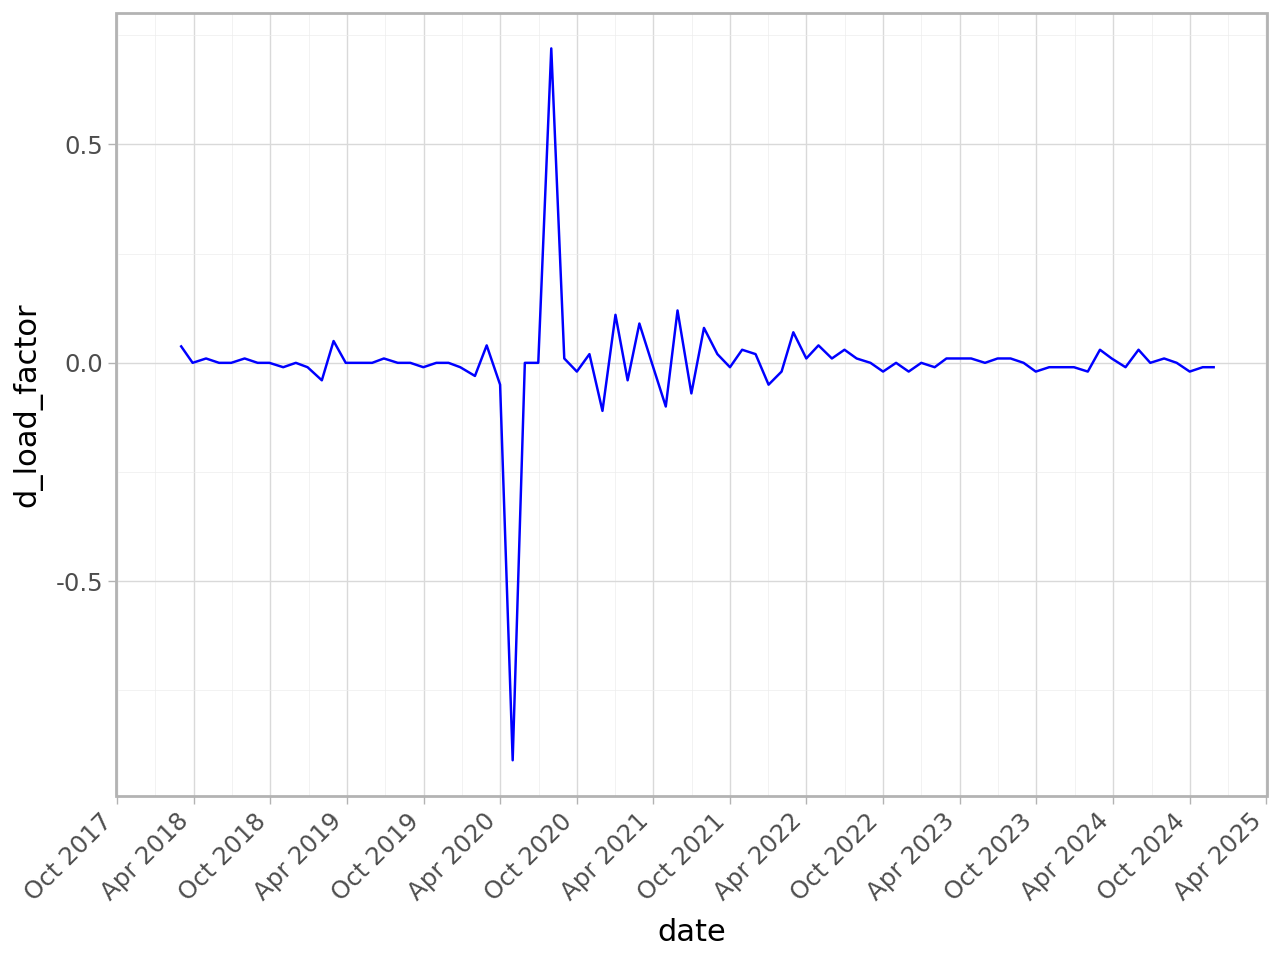

In [46]:
(
    ggplot(ts_monthly)
    + theme_light()
    + aes(x='date')
    + geom_line(aes(y='d_load_factor'), color='blue')
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

These seem much better. The only problem is that for the load factor, we can see some variance clustering around the lockdown period. For the sake of simplicity, we shall leave this issue as is. Also, for the number of guests, there seems to be some seasonality, so we might want to take seasonal differences there instead.

In [47]:
ts_monthly['sd_guests'] = ts_monthly['guests'] - ts_monthly['guests'].shift(12)

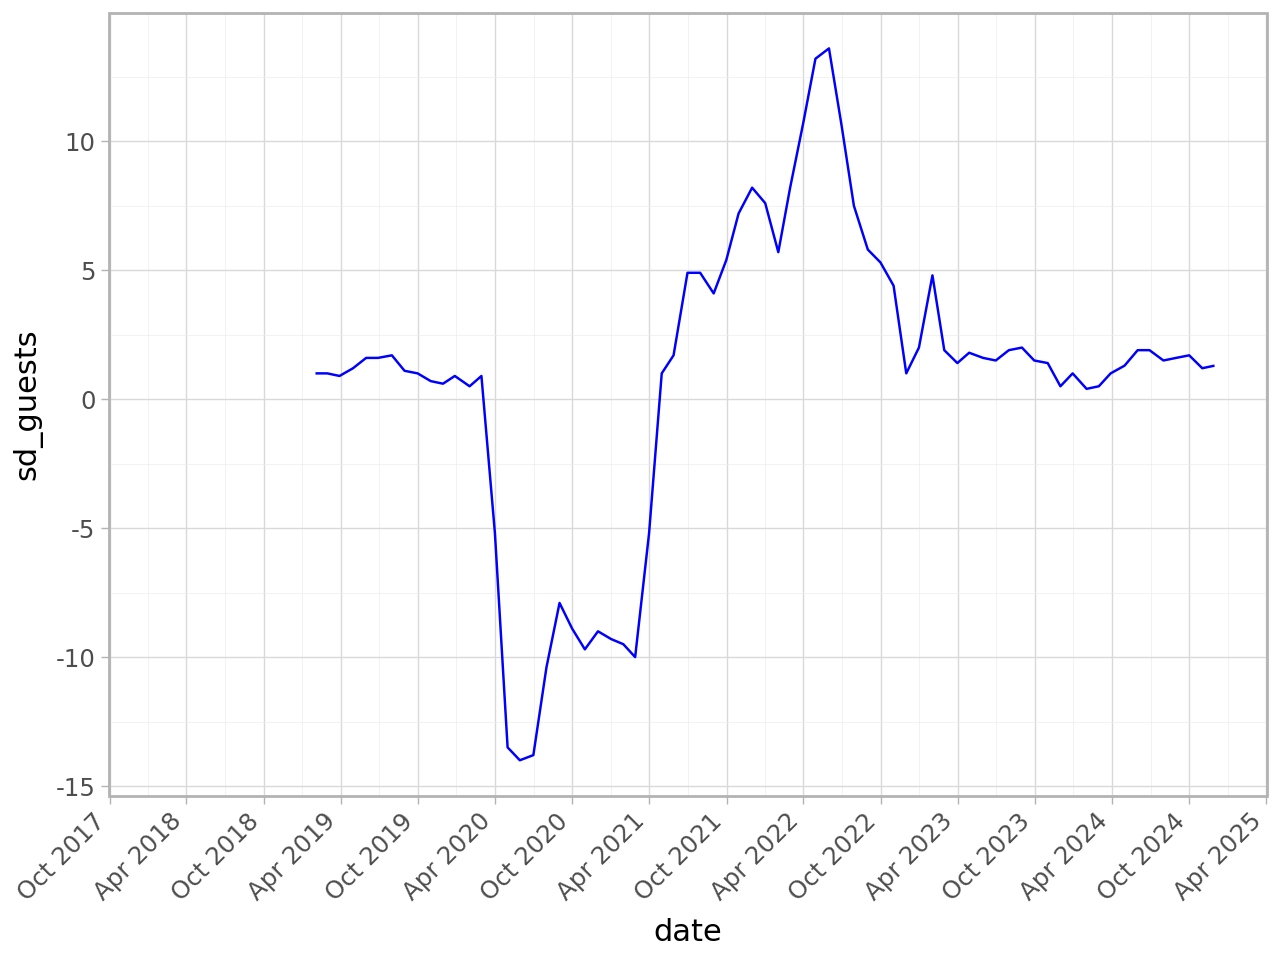

In [48]:
(
    ggplot(ts_monthly)
    + theme_light()
    + aes(x='date')
    + geom_line(aes(y='sd_guests'), color='blue')
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

As we can see, the seasonal difference shows a similar variance-clustering behaviour.

Let's also look at some lowess estimates for our two main variables of interest.

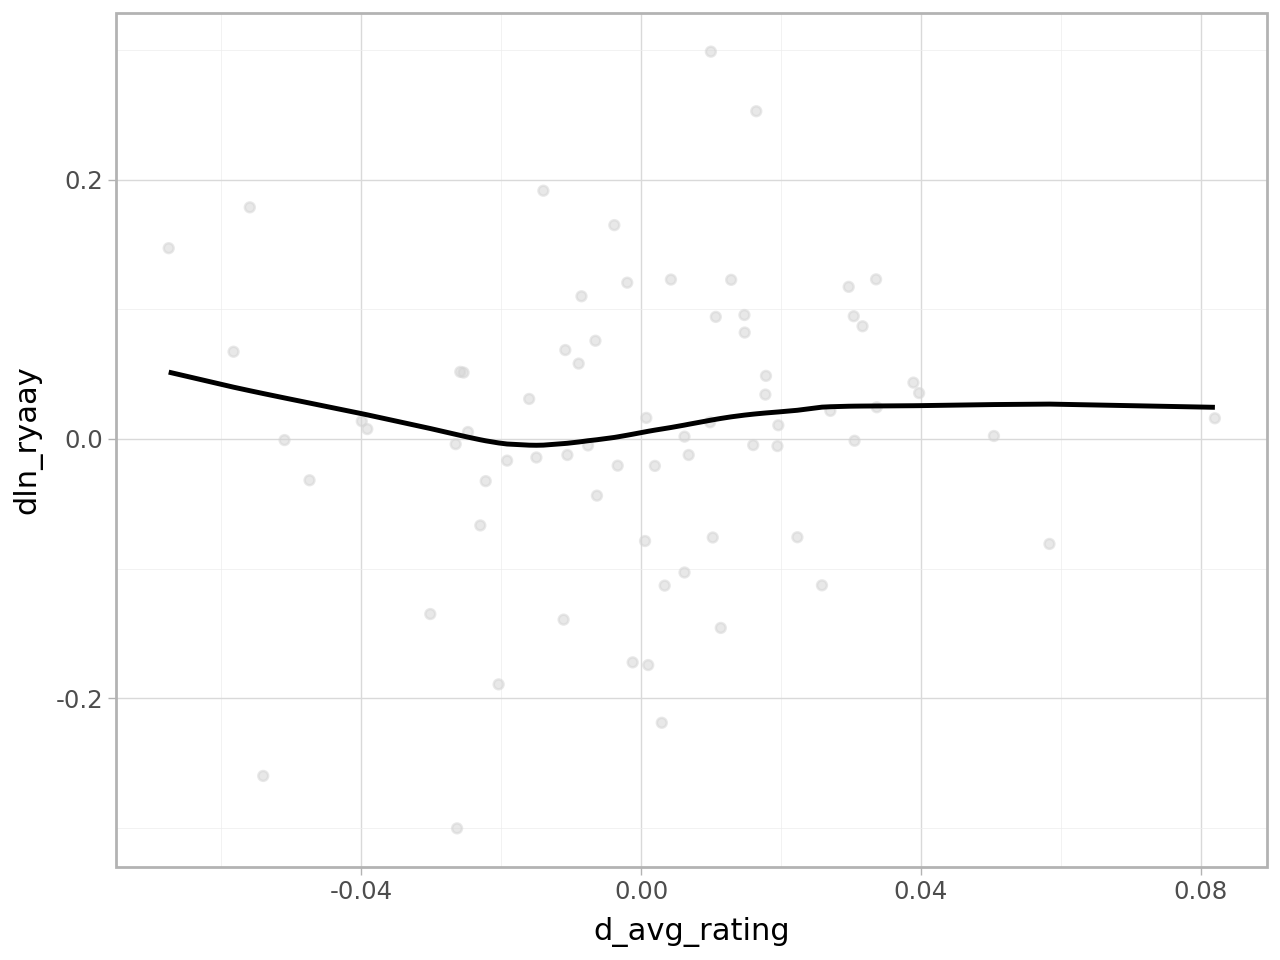

In [49]:
(
    ggplot(ts_monthly.dropna())
    + aes(x = 'd_avg_rating', y = 'dln_ryaay')
    + geom_point(color = 'lightgrey', alpha = 0.5)
    + geom_smooth(method = 'lowess', span = 0.9)
    + theme_light()
)

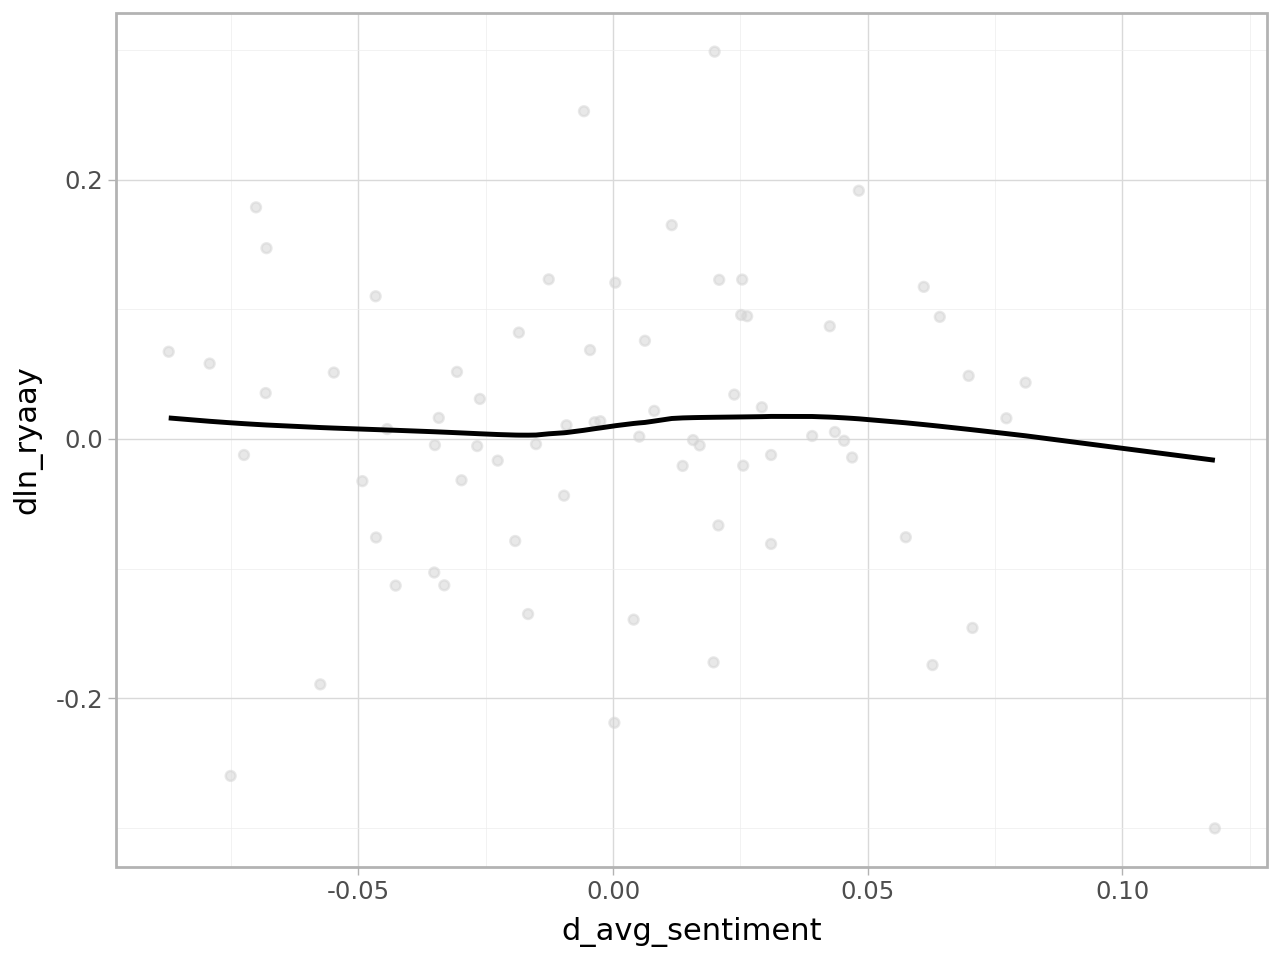

In [50]:
(
    ggplot(ts_monthly.dropna())
    + aes(x = 'd_avg_sentiment', y = 'dln_ryaay')
    + geom_point(color = 'lightgrey', alpha = 0.5)
    + geom_smooth(method = 'lowess', span = 0.9)
    + theme_light()
)

Both seem to have a different regime dependent on whether the difference is positive or negative. We shall adress this issue wiht linear splines.

In [51]:
def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    return design_matrix

Now we can estimate some regression models in increasing complexity. Interestingly, most of our models agree that there is a relationship between the log return of RYAAY and monthly average ratings and sentiments. For the interpretation, remember that both of these variables were scaled to a 0-1 scale before. Based on the below models, we can say the following:
- when the change in average ratings is negative, there is no significant relationship with price,
- for positive changes, a 0.01 unit change in average ratings is associated, on average, with a 1.5 - 2% increase in the montly returns,
- for negative changes in sentiments, a a 0.01 unit change is associated, on average, with a 0.5 - 1% increase in the montly returns,
- for positive changes in sentiments, a a 0.01 unit change is associated, on average, with a 1 - 1.5% decrease in the montly returns.

In [52]:
monthly_regs = []

monthly_regs.append(smf.ols("dln_ryaay ~ lspline(d_avg_rating, [0]) + lspline(d_avg_sentiment, [0])", 
                            data=ts_monthly).fit(cov_type='HAC', cov_kwds={'maxlags': 4}))

monthly_regs.append(smf.ols("dln_ryaay ~ lspline(d_avg_rating, [0]) + lspline(d_avg_sentiment, [0]) + lockdown + war + C(quarter)", 
                            data=ts_monthly).fit(cov_type='HAC', cov_kwds={'maxlags': 4}))

monthly_regs.append(smf.ols("dln_ryaay ~ lspline(d_avg_rating, [0]) + lspline(d_avg_sentiment, [0]) + d_guests*C(quarter) + d_load_factor*C(quarter) + lockdown + war", 
                            data=ts_monthly).fit(cov_type='HAC', cov_kwds={'maxlags': 4}))

monthly_regs.append(smf.ols("dln_ryaay ~ lspline(d_avg_rating, [0]) + lspline(d_avg_sentiment, [0]) + sd_guests + lockdown + war", 
                            data=ts_monthly).fit(cov_type='HAC', cov_kwds={'maxlags': 4}))

monthly_regs.append(smf.ols("dln_ryaay ~ lspline(d_avg_rating, [0]) + lspline(d_avg_sentiment, [0]) + d_guests*C(quarter) + lockdown + war", 
                            data=ts_monthly).fit(cov_type='HAC', cov_kwds={'maxlags': 4}))

monthly_regs.append(smf.ols("dln_ryaay ~ lspline(d_avg_rating, [0]) + lspline(d_avg_sentiment, [0]) + sd_guests + d_load_factor*C(quarter) + lockdown + war", 
                            data=ts_monthly).fit(cov_type='HAC', cov_kwds={'maxlags': 4}))

monthly_reg_tab = Stargazer(monthly_regs)

monthly_reg_tab.dependent_variable_name('Monthly RYAAY log returns')

monthly_reg_tab.covariate_order([
    'Intercept',
    'lspline(d_avg_rating, [0])[0]',
    'lspline(d_avg_rating, [0])[1]',
    'lspline(d_avg_sentiment, [0])[0]',
    'lspline(d_avg_sentiment, [0])[1]',
    'd_guests',
    'd_guests:C(quarter)[T.2]',
    'd_guests:C(quarter)[T.3]',
    'd_guests:C(quarter)[T.4]',
    'sd_guests',
    'd_load_factor',
    'd_load_factor:C(quarter)[T.2]',
    'd_load_factor:C(quarter)[T.3]',
    'd_load_factor:C(quarter)[T.4]',
    'C(quarter)[T.2]',
    'C(quarter)[T.3]',
    'C(quarter)[T.4]',
    'lockdown',
    'war'
    
])
monthly_reg_tab.rename_covariates(
    {
        'Intercept' : 'Constant',
        'lspline(d_avg_rating, [0])[0]' : 'FD avg. rating spline < 0',
        'lspline(d_avg_rating, [0])[1]' : 'FD avg. rating spline > 0',
        'lspline(d_avg_sentiment, [0])[0]' : 'FD avg. sentiment spline < 0',
        'lspline(d_avg_sentiment, [0])[1]' : 'FD avg. sentiment spline > 0',
        'd_guests' : 'FD guests',
        'd_guests:C(quarter)[T.2]' : 'FD guests x Q2',
        'd_guests:C(quarter)[T.3]' : 'FD guests x Q3',
        'd_guests:C(quarter)[T.4]' : 'FD guests x Q4',
        'sd_guests' : 'Seas. diff. guests (12m)',
        'd_load_factor' : 'FD load factor',
        'd_load_factor:C(quarter)[T.2]' : 'FD load factor x Q2',
        'd_load_factor:C(quarter)[T.3]' : 'FD load factor x Q3',
        'd_load_factor:C(quarter)[T.4]' : 'FD load factor x Q4',
        'C(quarter)[T.2]' : 'Q2',
        'C(quarter)[T.3]' : 'Q3',
        'C(quarter)[T.4]': 'Q4',
        'lockdown' : 'Lockdown shock dummy',
        'war' : 'War shock dummy'
    }
)
monthly_reg_tab.add_custom_notes(['Robust standard errors used (HAC).'])

monthly_reg_tab

We can also plot our predictions - once for the log returns, and once for the level price.

In [53]:
model_names = ["rating_sent_only", "time_dummies", "guests_qinteraction", "sd_guests_model",
               "guests_loadf_qinteraction", "sd_guests_loadf_qinteraction"]

logpred_names = [x + '_logpred' for x in model_names]
levelpred_names = [x + '_levelpred' for x in model_names]

for i in range(len(monthly_regs)):
    ts_monthly[logpred_names[i]] = np.nan
    prediction = monthly_regs[i].predict()
    ts_monthly[logpred_names[i]][ts_monthly.shape[0] - len(prediction):] = prediction
    
    start_price = float(ts_monthly['ryaay'][ts_monthly.shape[0] - len(prediction) - 1])
    
    ts_monthly[levelpred_names[i]] = np.nan
    
    ts_monthly.loc[ts_monthly.shape[0] - len(prediction), levelpred_names[i]] = start_price
    for j in range(ts_monthly.shape[0] - len(prediction) + 1, len(ts_monthly)):
        ts_monthly.loc[j, levelpred_names[i]] = ts_monthly.loc[j-1, levelpred_names[i]] * np.exp(ts_monthly.loc[j, logpred_names[i]])


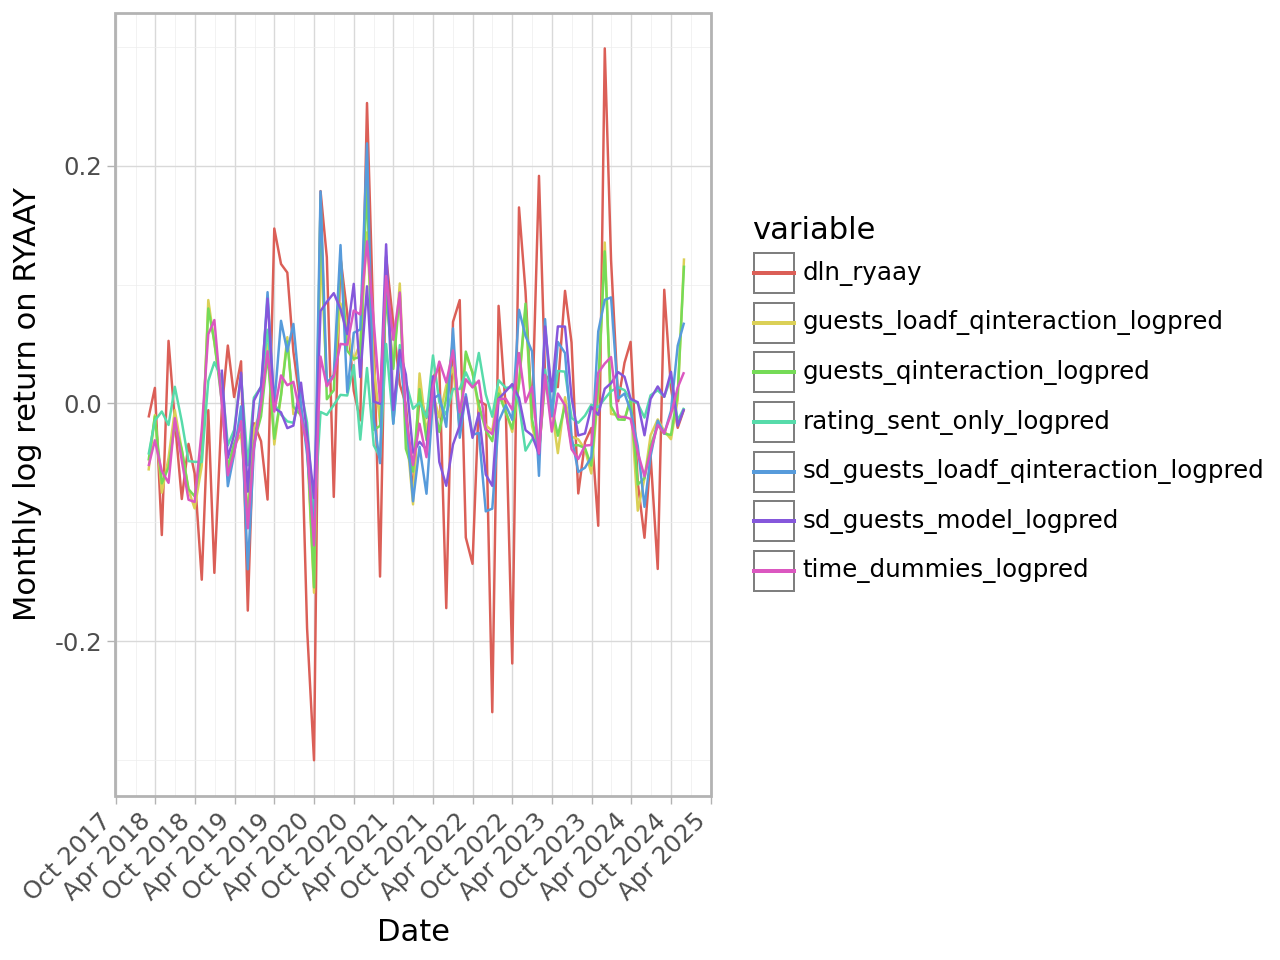

In [54]:
(
    ggplot(ts_monthly.melt(id_vars=['date'], value_vars=['dln_ryaay'] + logpred_names))
    + theme_light()
    + aes(x='date', y = 'value', color = 'variable')
    + geom_line()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x = 'Date', y = 'Monthly log return on RYAAY')
)

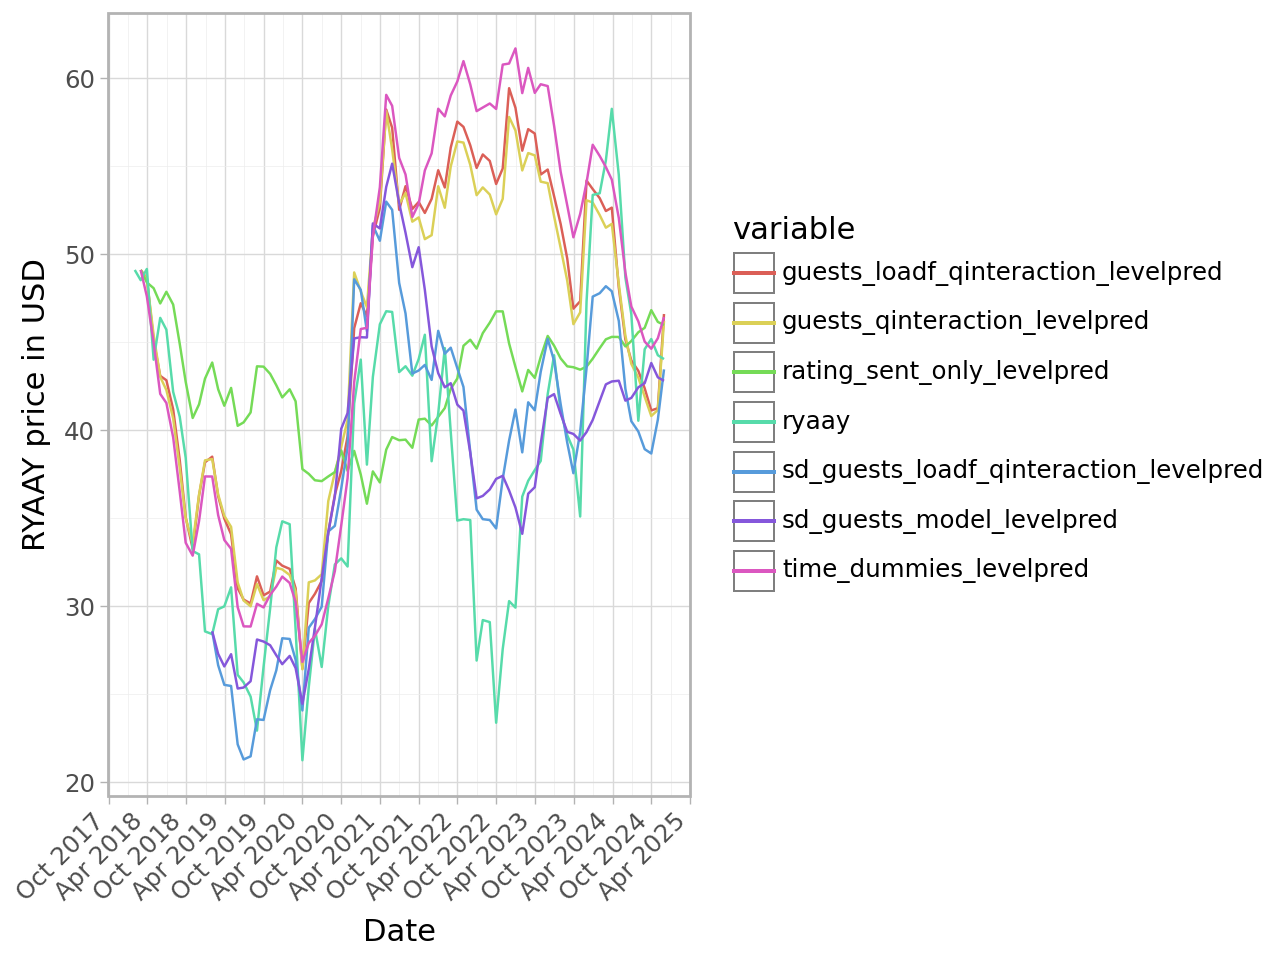

In [55]:
(
    ggplot(ts_monthly.melt(id_vars=['date'], value_vars=['ryaay'] + levelpred_names))
    + theme_light()
    + aes(x='date', y = 'value', color = 'variable')
    + geom_line()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x = 'Date', y = 'RYAAY price in USD')
)

As a sort of robustness check, we can also look at weekly level data - but bare in mind that we won't have the control variables scraped from Ryanair's website. We create the same variables as we did for the monthly set-up.

In [56]:
reviews_weekly = (
    reviews_df
    .groupby(['published_year', 'published_week'], as_index=False)
    .agg(avg_rating = ('rating', 'mean'),
         avg_sentiment =  ('sentiment_score', 'mean')
        )
)

ryaay_weekly = ryaay.groupby(['year', 'week']).last().reset_index()[['year', 'week', 'date', 'close']].rename(columns={'close': 'ryaay'})

In [57]:
ts_weekly = (ryaay_weekly
              .merge(reviews_weekly, how = 'outer', left_on=['year', 'week'], right_on=['published_year', 'published_week'])
             )
ts_weekly.drop(columns=['published_year', 'published_week'], inplace=True)

In [58]:
ts_weekly['lockdown'] = ts_weekly['date'].apply(lambda x: 1 if pd.Timestamp("2020-04-01T00:00:01") <= x <= pd.Timestamp("2021-04-30T23:59:59") else 0)
ts_weekly['war'] = ts_weekly['date'].apply(lambda x: 1 if pd.Timestamp("2022-02-01T00:00:01") <= x <= pd.Timestamp("2023-06-30T23:59:59") else 0)
ts_weekly['quarter'] = ts_weekly.date.dt.quarter

In [59]:
ts_weekly.sort_values('date', inplace=True)
ts_weekly.dropna(inplace=True)
ts_weekly.reset_index(drop = True, inplace=True)

In [60]:
for x in ["ryaay"]:
    ts_weekly["dln_" + x] = np.log(ts_weekly[x]) - np.log(ts_weekly[x].shift())

for x in ["avg_rating", "avg_sentiment"]:
    ts_weekly["d_" + x] = ts_weekly[x] - ts_weekly[x].shift()

Now let's calculate the regression estimates: one with only our variables of interest, and one with time dummies included as well. What we can see here, is that neither of the variables, which were significant in the monthly models, show up as significant here. So, our results turned out to be not quite robust, and we should not really use them for making decisions on whether to buy or sell Ryanair stock.

In [61]:
weekly_regs = []
weekly_regs.append(smf.ols("dln_ryaay ~ lspline(d_avg_rating, [0]) + lspline(d_avg_sentiment, [0])", data=ts_weekly).fit(cov_type = 'HAC', cov_kwds={'maxlags': 24}))
weekly_regs.append(smf.ols("dln_ryaay ~ lspline(d_avg_rating, [0]) + lspline(d_avg_sentiment, [0]) + war + lockdown + C(quarter)", data=ts_weekly).fit(cov_type = 'HAC', cov_kwds={'maxlags': 24}))
weekly_reg_tab = Stargazer(weekly_regs)
weekly_reg_tab.dependent_variable_name('Weekly RYAAY log returns')
weekly_reg_tab.covariate_order([
    'Intercept',
    'lspline(d_avg_rating, [0])[0]',
    'lspline(d_avg_rating, [0])[1]',
    'lspline(d_avg_sentiment, [0])[0]',
    'lspline(d_avg_sentiment, [0])[1]',
    'C(quarter)[T.2.0]',
    'C(quarter)[T.3.0]',
    'C(quarter)[T.4.0]',
    'lockdown',
    'war'
    
])

weekly_reg_tab.rename_covariates(
    {
        'Intercept' : 'Constant',
        'lspline(d_avg_rating, [0])[0]' : 'FD avg. rating spline < 0',
        'lspline(d_avg_rating, [0])[1]' : 'FD avg. rating spline > 0',
        'lspline(d_avg_sentiment, [0])[0]' : 'FD avg. sentiment spline < 0',
        'lspline(d_avg_sentiment, [0])[1]' : 'FD avg. sentiment spline > 0',
        'C(quarter)[T.2.0]' : 'Q2',
        'C(quarter)[T.3.0]' : 'Q3',
        'C(quarter)[T.4.0]': 'Q4',
        'lockdown' : 'Lockdown shock dummy',
        'war' : 'War shock dummy'
    }
)
weekly_reg_tab.add_custom_notes(['Robust standard errors used (HAC).'])

weekly_reg_tab

Again, we can create the same plots as we did for the monthly data.

In [62]:
weekly_model_names = ["weekly_rating_sent_only", "weekly_time_dummies"]

weekly_logpred_names = [x + '_logpred' for x in weekly_model_names]
weekly_levelpred_names = [x + '_levelpred' for x in weekly_model_names]

for i in range(len(weekly_regs)):
    ts_weekly[weekly_logpred_names[i]] = np.nan
    prediction = weekly_regs[i].predict()
    ts_weekly[weekly_logpred_names[i]][ts_weekly.shape[0] - len(prediction):] = prediction
    
    start_price = float(ts_weekly['ryaay'][ts_weekly.shape[0] - len(prediction) - 1])
    
    ts_weekly[weekly_levelpred_names[i]] = np.nan
    
    ts_weekly.loc[ts_weekly.shape[0] - len(prediction), weekly_levelpred_names[i]] = start_price
    for j in range(ts_weekly.shape[0] - len(prediction) + 1, len(ts_weekly)):
        ts_weekly.loc[j, weekly_levelpred_names[i]] = ts_weekly.loc[j-1, weekly_levelpred_names[i]] * np.exp(ts_weekly.loc[j, weekly_logpred_names[i]])


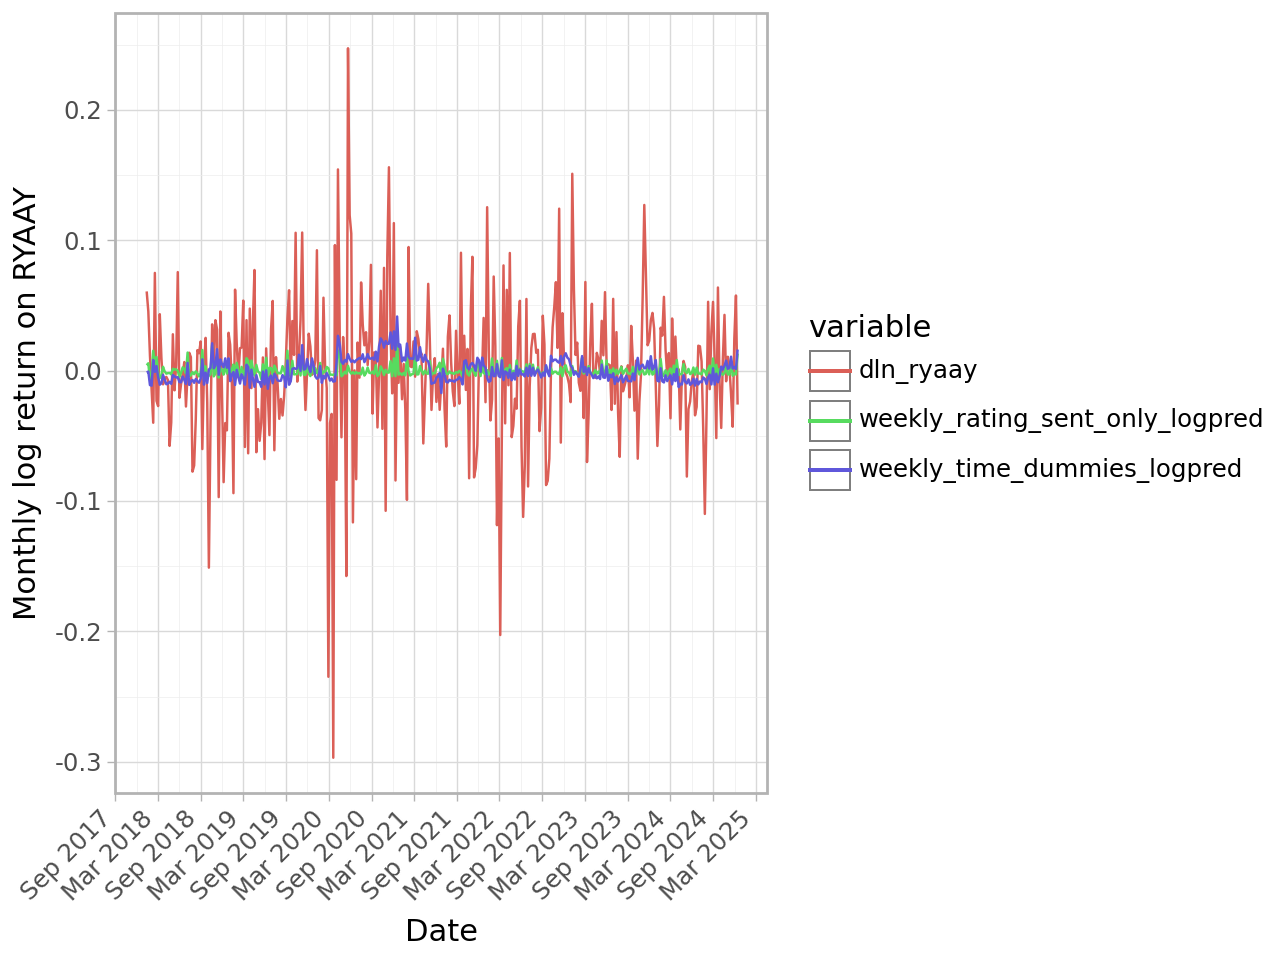

In [63]:
(
    ggplot(ts_weekly.melt(id_vars=['date'], value_vars=['dln_ryaay'] + weekly_logpred_names))
    + theme_light()
    + aes(x='date', y = 'value', color = 'variable')
    + geom_line()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x = 'Date', y = 'Monthly log return on RYAAY')
)

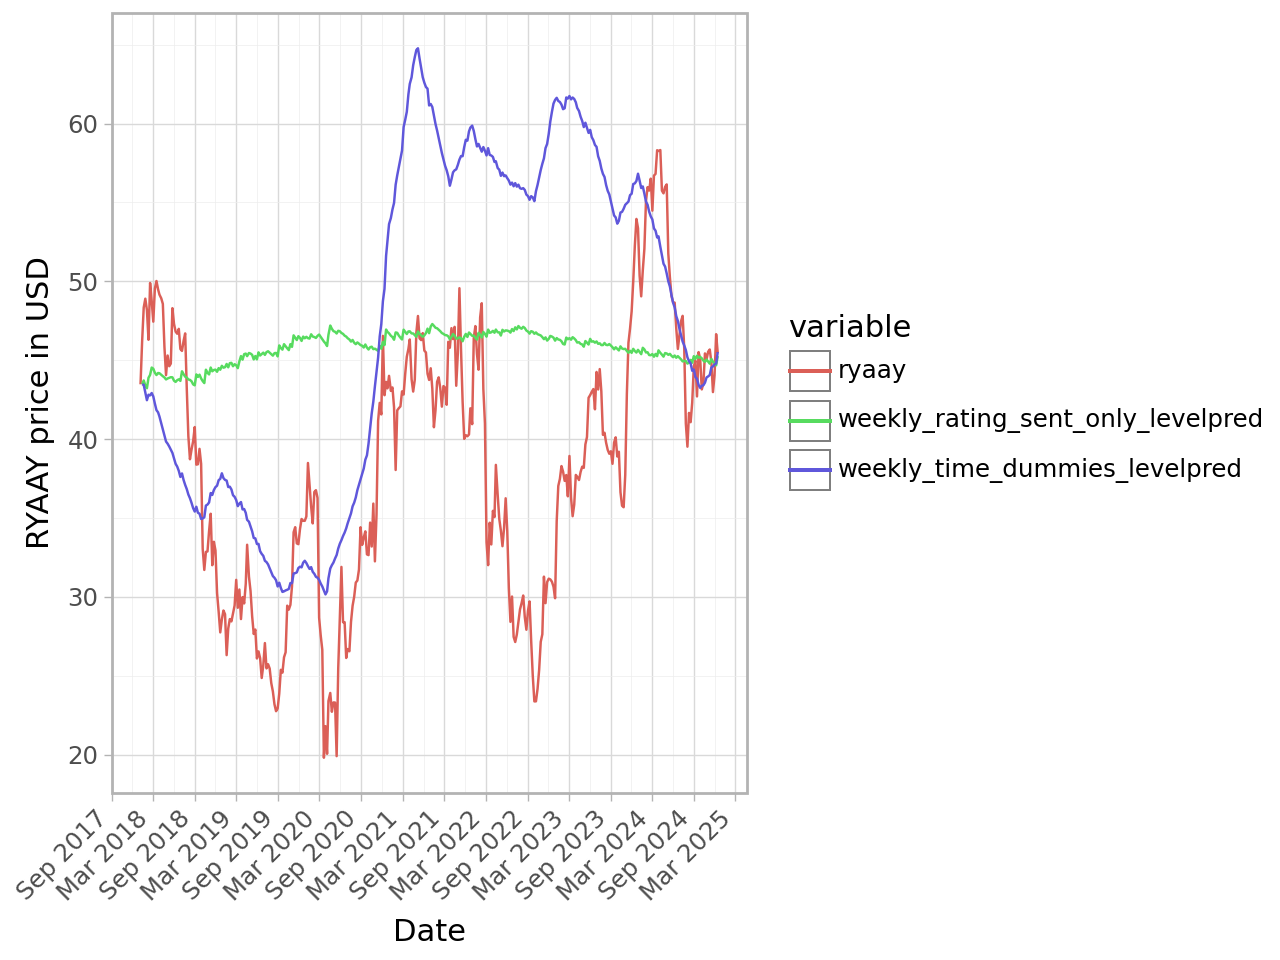

In [64]:
(
    ggplot(ts_weekly.melt(id_vars=['date'], value_vars=['ryaay'] + weekly_levelpred_names))
    + theme_light()
    + aes(x='date', y = 'value', color = 'variable')
    + geom_line()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x = 'Date', y = 'RYAAY price in USD')
)

Lastly, I save my results into CSV files, so that the Streamlit app that I will build upon this data can use it.

In [67]:
ts_monthly.to_csv(os.path.join('data', 'ts_monthly.csv'), index=False)

In [68]:
ts_weekly.to_csv(os.path.join('data', 'ts_weekly.csv'), index=False)